In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
importlib.reload(LSTM)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point



     N   T  MSE  STD
0   21  44  0.0  0.0
1   46  19  0.0  0.0
2   83   8  0.0  0.0
3   67  36  0.0  0.0
4    7   3  0.0  0.0
5   51   2  0.0  0.0
6   86  41  0.0  0.0
7    8  43  0.0  0.0
8   63  27  0.0  0.0
9   36  12  0.0  0.0
10  10  41  0.0  0.0
11  16  11  0.0  0.0
12  72  44  0.0  0.0
13  67   8  0.0  0.0
14  68  19  0.0  0.0
{'epochs': 600, 'T_Max': 48, 'reps': 15, 'N_Min': 2, 'N_Max': 100, 'Y': 'fco2', 'proc': 3, 'Searches': 8}


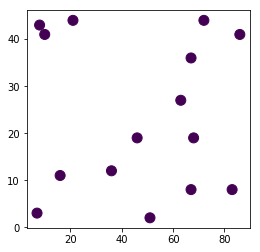

In [2]:
FillVar = 'fco2'
Runs,params = LSTM.Params('Full',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2
Finisehed Run  3
Finisehed Run  4
Finisehed Run  5
Finisehed Run  6
Finisehed Run  7
Finisehed Run  8
Finisehed Run  9
Finisehed Run  10
Finisehed Run  11
Finisehed Run  12
Finisehed Run  13


Using TensorFlow backend.


Finisehed Run  14
     N   T       MSE       STD
0   21  44  0.246444  0.025740
1   46  19  0.218735  0.026176
2   83   8  0.189948  0.027619
3   67  36  0.274908  0.165045
4    7   3  0.227548  0.042489
5   51   2  0.168563  0.021118
6   86  41  0.207843  0.033304
7    8  43  0.419234  0.066185
8   63  27  0.209764  0.018246
9   36  12  0.204438  0.032085
10  10  41  0.332389  0.052277
11  16  11  0.224626  0.033401
12  72  44  0.220748  0.030826
13  67   8  0.196308  0.030813
14  68  19  0.212643  0.021040


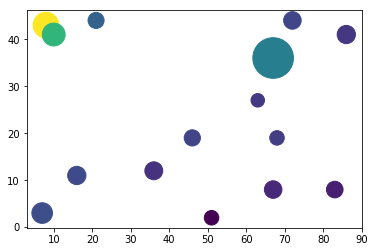

Using TensorFlow backend.


In [3]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','Rain','Water Table']

# FullModel = ['Wind Spd','air pressure','Water Table','PPFD','Ts 2.5 cm']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = 'Fch4'
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
#         plt.plot(RST.Master['fch4'],color='grey')
        plt.plot(RST.Master['TempFill'],color='blue',alpha=.5)  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

[ 53.32219933   2.97882246]
53 3


Using TensorFlow backend.


[ 50.79784864   4.55064483]
51 5
[ 48.81339676   3.42246045]
49 3
[ 52.96561917   0.20045111]
53 0
[  4.92459542e+01   3.37663884e-02]
49 0
[ 53.69317294   5.78272558]
54 6
[ 48.29379991   5.84379251]
48 6
[ 50.64038116   7.78748817]
51 8
         MSE   N       STD   T
0   0.227548   7  0.042489   3
1   0.419234   8  0.066185  43
2   0.332389  10  0.052277  41
3   0.224626  16  0.033401  11
4   0.246444  21  0.025740  44
5   0.204438  36  0.032085  12
6   0.218735  46  0.026176  19
7   0.187777  48  0.022589   6
8   0.197147  49  0.030762   0
9   0.181846  49  0.028999   3
10  0.168563  51  0.021118   2
11  0.177480  51  0.025215   5
12  0.197715  51  0.023789   8
13  0.193231  53  0.029971   0
14  0.179844  53  0.026265   3
15  0.191235  54  0.023470   6
16  0.209764  63  0.018246  27
17  0.196308  67  0.030813   8
18  0.274908  67  0.165045  36
19  0.212643  68  0.021040  19
20  0.220748  72  0.030826  44
21  0.189948  83  0.027619   8
22  0.207843  86  0.033304  41
Optimum:
        

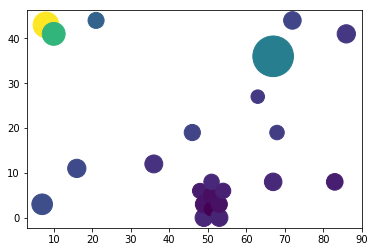

In [4]:

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
        if N < params['N_Min'] or N > params['N_Max']:
            N -= int(o*np.cos(o*np.pi))
        if o > 5:
            T += 1
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    params['T'] = T
    params['N'] = N
    
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print('Optimum:')
print(Optimum)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Level:  1

['Wind Spd']

['air pressure']

['Ta']

['PPFD']

['Ts 2.5 cm']

['Ts 15 cm']


Using TensorFlow backend.



['VWC']


Using TensorFlow backend.
Using TensorFlow backend.



['Active Layer']

['Rain']

['Water Table']
Best:
['PPFD'] 0.276000417727
Level:  2

['Wind Spd', 'PPFD']

['air pressure', 'PPFD']

['Ta', 'PPFD']

['PPFD', 'Ts 2.5 cm']

['PPFD', 'Ts 15 cm']

['PPFD', 'VWC']

['PPFD', 'Active Layer']

['PPFD', 'Rain']

['PPFD', 'Water Table']
Best:
['PPFD', 'Active Layer'] 0.242535054301
Level:  3

['Wind Spd', 'PPFD', 'Active Layer']

['air pressure', 'PPFD', 'Active Layer']


Using TensorFlow backend.
Using TensorFlow backend.



['Ta', 'PPFD', 'Active Layer']


Using TensorFlow backend.



['PPFD', 'Ts 2.5 cm', 'Active Layer']

['PPFD', 'Ts 15 cm', 'Active Layer']

['PPFD', 'VWC', 'Active Layer']

['PPFD', 'Active Layer', 'Rain']

['PPFD', 'Active Layer', 'Water Table']
Best:
['Ta', 'PPFD', 'Active Layer'] 0.216501436016
Level:  4

['Wind Spd', 'Ta', 'PPFD', 'Active Layer']

['air pressure', 'Ta', 'PPFD', 'Active Layer']

['Ta', 'PPFD', 'Ts 2.5 cm', 'Active Layer']

['Ta', 'PPFD', 'Ts 15 cm', 'Active Layer']

['Ta', 'PPFD', 'VWC', 'Active Layer']

['Ta', 'PPFD', 'Active Layer', 'Rain']

['Ta', 'PPFD', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'Ta', 'PPFD', 'Active Layer'] 0.185037263711
Level:  5

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Active Layer']


Using TensorFlow backend.
Using TensorFlow backend.



['Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer']


Using TensorFlow backend.



['Wind Spd', 'Ta', 'PPFD', 'Active Layer', 'Rain']

['Wind Spd', 'Ta', 'PPFD', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer'] 0.17088433915
Level:  6

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'VWC', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer', 'Rain']

['Wind Spd', 'Ta', 'PPFD', 'VWC', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer'] 0.170510319801
Level:  7

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain']

['Wind Spd', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer'] 0.1684972

Using TensorFlow backend.
Using TensorFlow backend.



['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain'] 0.168925771913
Level:  9

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain']

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']


Using TensorFlow backend.


Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain'] 0.168636106452
Level:  10

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table'] 0.168537517755
          CI       MSE                                             Models
1   0.017046  0.276000                                        Model: PPFD
2   0.014756  0.242535                           Model: PPFD+Active Layer
3   0.014839  0.216501                        Model: Ta+PPFD+Active Layer
4   0.012389  0.185037               Model: Wind Spd+Ta+PPFD+Active Layer
5   0.009753  0.170884           Model: Wind Spd+Ta+PPFD+VWC+Active Layer
6   0.009689  0.170510  Model: Wind Spd+Ta+PPFD+Ts 15 cm+VWC+Active Layer
7   0.009607  0.168497  Model: Wind Spd+air pressure+Ta+PPFD+Ts 15 cm+...
8   0.010772  0.168926  Mod

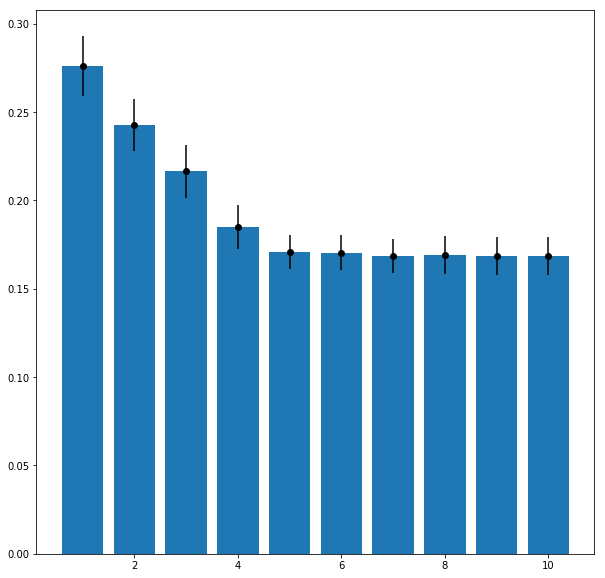

In [5]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]


Results = RunReps(FullModel,params,pool,FullReturn=True)
FullScore = Results[0]
Data = Results[1]


BestMSE = []
BestSTD = []
idx = []
BestModels = []

print(FullModel)

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    STD = []
    Model_Names = []
    
    for model in Models:
        print()
        print(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        Score.append(MSE.mean())
        STD.append(MSE.std())
        Data['Model: '+'+'.join(model)] = Results[1]
        Model_Names.append('Model: '+'+'.join(model))
        
    Score = np.asanyarray(Score)
    STD = np.asanyarray(STD)
#     print(Model_Names)
#     print(np.where(Score == Score.min())[0][0])
    Best = Models[np.where(Score == Score.min())[0][0]]
    Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best_Name)
    BestMSE.append(Score.min())
    BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
BestSTD = np.asanyarray(BestSTD)
idx = np.asanyarray(idx)
BestSE = BestSTD/(params['reps']**.5)
BestCI = BestSE*1.96
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)
plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
print(Stats)

Data.to_csv('GapFilled'+FillVar+'.csv')

In [6]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

12400.822437763214


In [7]:

# d = {'Models':BestModels,'MSE':BestMSE,'STD':BestSTD}
# Stats = pd.DataFrame(index=idx,data=d)
# Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

In [8]:
print(Score)

[ 0.16853752]


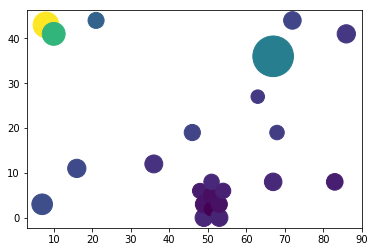

In [9]:

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
# 

# gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

# next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
# print(next_x)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)